# **Загрузка всех библиотек**

В этом разделе загрузили основные библиотеки. Некоторые другие могут догружаться по мере надобности внутри других разделов.

Библиотеки для парсинга страниц:

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import re

Библиотеки для работы с PDF:

In [ ]:
!pip install pymupdf
import fitz

Библиотека для расстановки по алфавиту:

In [ ]:
import string

Библиотеки для токенизации, лемматизации финского языка

In [ ]:
!pip install stanza

In [ ]:
import stanza
stanza.download('fi')
nlp = stanza.Pipeline('fi', processors='tokenize,pos,lemma')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: fi (Finnish) ...
INFO:stanza:File exists: /root/stanza_resources/fi/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: fi (Finnish):
| Processor | Package      |
----------------------------
| tokenize  | tdt          |
| mwt       | tdt          |
| pos       | tdt_charlm   |
| lemma     | tdt_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Библиотеки для подсчета

In [ ]:
from collections import Counter

Библиотеки для визуализации: построения графиков

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# **Выгрузка первого текста**

P.S. Выгрузка с сайта может занять до 5 минут, т.к. в тексте много страниц

In [ ]:
#загружаем текст с интернет-страницы
def get_text(url):
    response = requests.get(url)
    response.encoding = "utf-8"

    soup = BeautifulSoup(response.text, "html.parser")
    text_blocks = soup.find_all("br")
    text = ""
    for br in text_blocks:
        if br.next_sibling and isinstance(br.next_sibling, str):
            line = br.next_sibling.strip()
            if not re.search(r'\(1918\)|Här nedan syns|mode=normal|https://runeberg.org/ahvenkulta/\d{4}\.html', line):
                text += line + "\n"
    return text.strip()

#собираем все тексты со всех страниц книги
def scrape_book(base_url, start_page, end_page):
    all_text = ""

    for i in range(start_page, end_page + 1, 1):
        page_number = str(i).zfill(4)
        url = f"{base_url}{page_number}.html"
        page_text = get_text(url)
        all_text += page_text + "\n\n"
        time.sleep(1)

    return all_text

#задаем параметры для газгрузки
if __name__ == "__main__":
    base_url = "https://runeberg.org/ahvenkulta/"
    start_page = 9   #первая страница книги
    end_page = 142   #последняя страница

    purefinnish_text = scrape_book(base_url, start_page, end_page)

#Сохраняем в файл
    with open("purefinnish_text.txt", "w", encoding="utf-8") as file:
        file.write(purefinnish_text)

Посчитаем, сколько слов получилось в итоговом файле

In [ ]:
with open("purefinnish_text.txt", "r", encoding="utf-8") as f:
    text = f.read()
words = text.split()
print(f"Количество слов: {len(words)}")

Количество слов: 12368


# **Выгрузка текста с заимствованиями**

Извлечем текст из PDF- файла

In [ ]:
def loanwords_text(Gradu, skip_pages=None):
    text = ""
    skip_pages = set(skip_pages) if skip_pages else set()

    with fitz.open(Gradu) as doc:
        for page_num, page in enumerate(doc, start=1):
          if page_num in skip_pages:
            continue
          text += page.get_text("text") + "\n"
    return text

#Задаем параметры парсинга
pdf_file = "Gradu.pdf"
skip_pages = {2, 11, 13} | set(range(69, 78))
loanwords_text = loanwords_text(pdf_file, skip_pages)

#Сохраняем в файл
with open("loanwords_text.txt", "w", encoding="utf-8") as f:
    f.write(loanwords_text)

Убираю из текста слова на другом языке (английском)

In [ ]:
!pip install lingua-language-detector

from lingua import Language, LanguageDetectorBuilder

EXCEPTIONS = {"on", "enantiomeerin", "enantiomeeri",
              "enantiomeeria", "enantiomeerien", "polystyreenin",
              "prioriteetin", "bromi", "happea"}

def detect(word):
    if word.lower() in EXCEPTIONS:
        return "FINNISH", 1.0
    languages = [Language.ENGLISH, Language.FINNISH]
    detector = LanguageDetectorBuilder.from_languages(*languages).build()

    confidence_values = detector.compute_language_confidence_values(word)
    finnish_confidence = next((x.value for x in confidence_values if x.language == Language.FINNISH), 0)
    return finnish_confidence >= 0.5

with open("loanwords_text.txt", "r", encoding="utf-8") as f:
    words = f.read().split()

finnish_words = [word for word in words if detect(word)]

with open("loanwords_text_finnishonly.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(finnish_words))

Посчитаем, сколько слов получилось в итоговом файле

In [ ]:
with open("loanwords_text_finnishonly.txt", "r", encoding="utf-8") as f:
    text = f.read()
words = text.split()
print(f"Количество слов: {len(words)}")

Количество слов: 9438


# **Предобработка текстов**

В данной части я провожу предобработку текстов: очищаю их от знаков препинания, аббревиатур, цифр, скобок, повторов, пробелов. Также привожу их к единому формату: нижнему регистру.

In [ ]:
def preprocess_text(file_path, output_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление цифр
    text = re.sub(r'\d+', '', text)

    # Удаление содержимого в скобках (круглых и квадратных)
    text = re.sub(r'\(.*?\)|\[.*?\]', '', text, flags=re.DOTALL)

    # Удаление аббревиатур (слов с точками)
    text = re.sub(r'\b(?:[a-zäöå]+\.){2,}\b', '', text)

    # Удаление пунктуации
    text = re.sub(r'[^\w\säöå]', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    # Удаление повторяющихся слов
    words = text.split()
    seen = set()
    unique_words = []

    for word in words:
        if word not in seen and len(word) > 2:
          seen.add(word)
          unique_words.append(word)

    cleaned_text = ' '.join(unique_words)

    with open(output_path, 'w', encoding='utf-8') as output_file:
        output_file.write(cleaned_text)

input_files = ['purefinnish_text.txt', 'loanwords_text_finnishonly.txt']
output_files = ['clean_pure_text.txt', 'clean_loanwords_text.txt']

Посчитаем количество слов в итоговых файлах

In [ ]:
def count_words(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        words = file.read().split()
        return len(words)

file1 = "clean_pure_text.txt"
file2 = "clean_loanwords_text.txt"

word_count1 = count_words(file1)
word_count2 = count_words(file2)

print(f"Итого, количество слов в чисто финском тексте: {word_count1}")
print(f"Итого, количество слов в тексте с заимствованиями: {word_count2}")

Итого, количество слов в чисто финском тексте: 4960
Итого, количество слов в тексте с заимствованиями: 1317


# Частотный анализ

Это дополнительный раздел. Он никак не влияет на наши результаты, но получаются интересные факты.

### 1. Средняя длина слов

In [ ]:
def average_word_length(file_path):
   with open(file_path, "r", encoding="utf-8") as file:
      words = [word for line in file for word in line.strip().split() if word.isalpha()]
   avg_length = np.mean([len(word) for word in words]) if words else 0
   print(f"Средняя длина слова в {file_path}: {avg_length:.2f}")
   return avg_length

files = ["clean_pure_text.txt", "clean_loanwords_text.txt"]

for file in files:
    average_word_length(file)

Средняя длина слова в clean_pure_text.txt: 8.59
Средняя длина слова в clean_loanwords_text.txt: 10.22


### 2. Анализ частоты гласных в общем и по ряду

In [ ]:
def all_vowels(vowel_file):
    with open(vowel_file, "r", encoding="utf-8") as f:
        vowels = f.read().strip().split()
    return vowels

def all_words (file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        words = file.read().lower().split()
    return words

def vowel_frequencies(file_path, finnish_vowels):
    vowels = all_vowels(finnish_vowels)
    words = all_words(file_path)

    front_vowels = {"ä", "ö", "y"}
    back_vowels = {"a", "o", "u"}
    mid_vowels = {"e", "i"}

    vowel_counts = Counter()
    front_count, back_count, mid_count = 0, 0, 0
    start_vowel_counts = Counter()
    middle_vowel_counts = Counter()
    end_vowel_counts = Counter()

    for word in words:
        word_vowels = [ch for ch in word if ch in vowels]
        vowel_counts.update(word_vowels)

        if any(ch in front_vowels for ch in word_vowels):
            front_count += 1
        if any(ch in back_vowels for ch in word_vowels):
            back_count += 1
        if any(ch in mid_vowels for ch in word_vowels):
            mid_count += 1

        if word_vowels:
            start_vowel_counts[word_vowels[0]] += 1
            if len(word_vowels) > 2:
                middle_vowel_counts[word_vowels[len(word_vowels)//2]] += 1
            end_vowel_counts[word_vowels[-1]] += 1
    return vowel_counts, front_count, mid_count, back_count, start_vowel_counts, middle_vowel_counts, end_vowel_counts

file1 = "clean_pure_text.txt"
file2 = "clean_loanwords_text.txt"
vowel_file = "finnish_vowels.txt"

freq1, front1, back1,mid1, start1, middle1, end1 = vowel_frequencies(file1, vowel_file)
freq2, front2, back2, mid2, start2, middle2, end2 = vowel_frequencies(file2, vowel_file)

print("\nЧастота гласных в Тексте 1:", freq1)
print("Частота гласных в Тексте 2:", freq2)

print(f"\nПередние гласные: Текст 1 -> {front1}, Текст 2 -> {front2}")
print(f"Средние гласные: Текст 1 -> {mid1}, Текст 2 -> {mid2}")
print(f"Задние гласные: Текст 1 -> {back1}, Текст 2 -> {back2}")

print("\nЧастота гласных в начале слова:")
print("Текст 1:", start1)
print("Текст 2:", start2)

print("\nЧастота гласных в середине слова:")
print("Текст 1:", middle1)
print("Текст 2:", middle2)

print("\nЧастота гласных в конце слова:")
print("Текст 1:", end1)
print("Текст 2:", end2)



Частота гласных в Тексте 1: Counter({'a': 5060, 'i': 4610, 'e': 3501, 'u': 2312, 'ä': 2107, 'o': 1796, 'y': 762, 'ö': 155})
Частота гласных в Тексте 2: Counter({'i': 1647, 'a': 1345, 'e': 1193, 'o': 663, 'u': 616, 'ä': 562, 'y': 356, 'ö': 66})

Передние гласные: Текст 1 -> 1432, Текст 2 -> 458
Средние гласные: Текст 1 -> 3456, Текст 2 -> 955
Задние гласные: Текст 1 -> 4049, Текст 2 -> 1156

Частота гласных в начале слова:
Текст 1: Counter({'a': 1243, 'u': 871, 'i': 802, 'o': 667, 'e': 629, 'ä': 405, 'y': 316, 'ö': 27})
Текст 2: Counter({'a': 306, 'o': 227, 'i': 202, 'u': 198, 'e': 180, 'ä': 109, 'y': 89, 'ö': 6})

Частота гласных в середине слова:
Текст 1: Counter({'i': 1093, 'a': 945, 'e': 781, 'u': 523, 'ä': 438, 'o': 393, 'y': 188, 'ö': 47})
Текст 2: Counter({'i': 355, 'e': 236, 'a': 213, 'u': 121, 'o': 103, 'ä': 101, 'y': 67, 'ö': 10})

Частота гласных в конце слова:
Текст 1: Counter({'a': 1669, 'i': 1097, 'e': 902, 'ä': 760, 'u': 262, 'o': 162, 'y': 84, 'ö': 24})
Текст 2: Counter

### Визуализация частотности гласных

Для более показательной визуализации привожу все к процентам

In [ ]:
def normalized_frequencies(freq, total_vowels):
    return {vowel: (count / total_vowels) * 100 for vowel, count in freq.items()}

# Считаем общее количество гласных в каждом тексте
total_vowels1 = sum(freq1.values())
total_vowels2 = sum(freq2.values())

# Преобразуем в проценты
freq1_percent = normalized_frequencies(freq1, total_vowels1)
freq2_percent = normalized_frequencies(freq2, total_vowels2)


Строю график

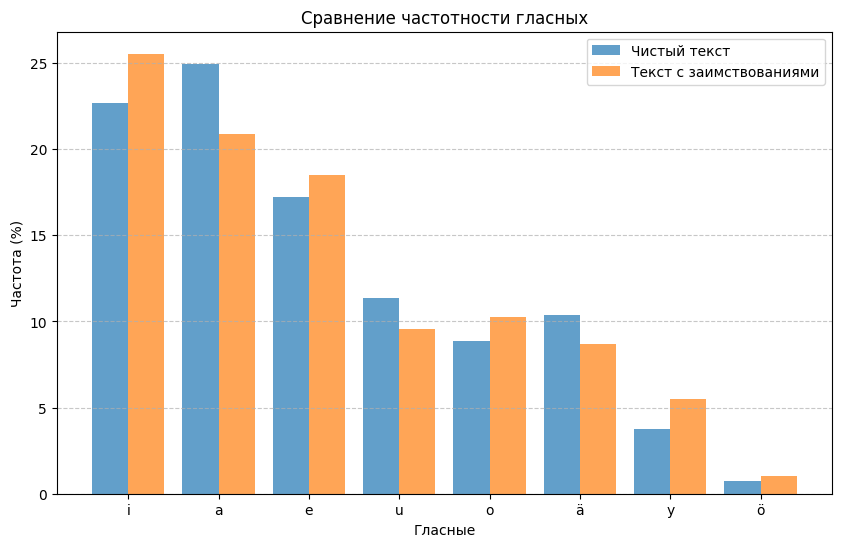

In [ ]:
def visualize_frequencies(freq1, freq2):

    combined_freq = {vowel: freq1.get(vowel, 0) + freq2.get(vowel, 0) for vowel in set(freq1) | set(freq2)}
   #сортирую по убыванию частоты
    sorted_vowels = sorted(combined_freq.keys(), key=lambda v: combined_freq[v], reverse=True)

    values1 = [freq1.get(vowel, 0) for vowel in sorted_vowels]
    values2 = [freq2.get(vowel, 0) for vowel in sorted_vowels]

    x = np.arange(len(sorted_vowels))

    plt.figure(figsize=(10, 6))
    width = 0.4

    plt.bar(x - width/2, values1, width=width, label="Чистый текст", alpha=0.7)
    plt.bar(x + width/2, values2, width=width, label="Текст с заимствованиями", alpha=0.7)

    plt.xlabel("Гласные")
    plt.ylabel("Частота (%)")
    plt.title("Сравнение частотности гласных")
    plt.xticks(ticks=x, labels=sorted_vowels)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

visualize_frequencies(freq1_percent, freq2_percent)

### Визуализация частотности гласных *по* ряду

В данном разделе исследуется не общая частотность, а частотность именно рядов гласных.

In [ ]:
total_vowels1 = sum(freq1.values())
total_vowels2 = sum(freq2.values())

front1_total = sum(freq1[v] for v in ["ä", "ö", "y"] if v in freq1)
mid1_total = sum(freq1[v] for v in ["e", "i"] if v in freq1)
back1_total = sum(freq1[v] for v in ["a", "o", "u"] if v in freq1)

front2_total = sum(freq2[v] for v in ["ä", "ö", "y"] if v in freq2)
mid2_total = sum(freq2[v] for v in ["e", "i"] if v in freq2)
back2_total = sum(freq2[v] for v in ["a", "o", "u"] if v in freq2)

front1_percent = (front1_total / total_vowels1) * 100
mid1_percent = (mid1_total / total_vowels1) * 100
back1_percent = (back1_total / total_vowels1) * 100

front2_percent = (front2_total / total_vowels2) * 100
mid2_percent = (mid2_total / total_vowels2) * 100
back2_percent = (back2_total / total_vowels2) * 100

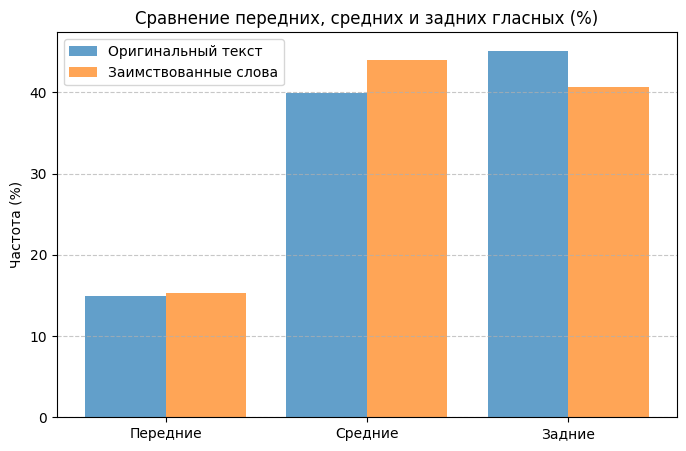

In [ ]:
def front_mid_back_bar_chart(front1, mid1, back1, front2, mid2, back2):
    categories = ["Передние", "Средние", "Задние"]
    values1 = [front1, mid1, back1]
    values2 = [front2, mid2, back2]

    x = np.arange(len(categories))

    plt.figure(figsize=(8, 5))
    plt.bar(x - 0.2, values1, width=0.4, label="Оригинальный текст", alpha=0.7)
    plt.bar(x + 0.2, values2, width=0.4, label="Заимствованные слова", alpha=0.7)

    plt.xticks(ticks=x, labels=categories)
    plt.ylabel("Частота (%)")
    plt.title("Сравнение передних, средних и задних гласных (%)")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

front_mid_back_bar_chart(front1_percent, mid1_percent, back1_percent,
                         front2_percent, mid2_percent, back2_percent)


# **БЕЗ ЛЕММАТИЗАЦИИ**

Перейдем непосредственно к исследованию.

Сначала проанализируем тексты без лемматизации (интересно, как измениться результат после того, как отбросим все суффиксы и окончания - они ведь тоже присоединяются по правилам гармонии гласных).

In [ ]:
#Сначала мне надо задать категории гласных по ряду (передние, средние задние)
def load_vowels(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        line = file.read().strip()

    vowels_list = line.split()

    front_vowels = {"ä", "ö", "y"}
    back_vowels = {"a", "o", "u"}
    neutral_vowels = {"e", "i"}

    vowels = {
        "передние": set(),
        "задние": set(),
        "средние": set()
    }

    for vowel in vowels_list:
        if vowel in front_vowels:
            vowels["передние"].add(vowel)
        elif vowel in back_vowels:
            vowels["задние"].add(vowel)
        elif vowel in neutral_vowels:
            vowels["средние"].add(vowel)

    return vowels

#СОБСТВЕННО ПРОВЕРКА
#Здесь проверка каждого отдельного слова
def check_vowel_harmony(word, vowels):
    front_vowel = any(char in vowels["передние"] for char in word)
    back_vowel = any(char in vowels["задние"] for char in word)
    return not (front_vowel and back_vowel)

#Принимаем текст и список гласных, возвращаем список с нарушениями
def analyze_text_for_harmony(text, vowels):
    words = text.split()
    disharmonic_words = [word for word in words if not check_vowel_harmony(word, vowels)]
    return disharmonic_words

#Читаем файл, анализируем и загружаем слова с нарушениями в новый файл
def analyze(input_file, vowels_file, output_file):
    with open(input_file, "r", encoding="utf-8") as file:
        text = file.read()

    vowels = load_vowels(vowels_file)
    disharmonic_words = analyze_text_for_harmony(text, vowels)

    with open(output_file, "w", encoding="utf-8") as file:
        file.write("\n".join(disharmonic_words))

#Дополнительно еще включаем счетчик слов и запускаем всю функцию
    print(f"Файл {output_file} содержит {len(disharmonic_words)} слов, нарушающих сингармонизм.")

def main():
    vowels_file = "finnish_vowels.txt"
    analyze("clean_pure_text.txt", vowels_file, "pure_harmony_no_lemm.txt")
    analyze("clean_loanwords_text.txt", vowels_file, "loanwords_harmony_no_lemm.txt")

if __name__ == "__main__":
    main()

Файл pure_harmony_no_lemm.txt содержит 183 слов, нарушающих сингармонизм.
Файл loanwords_harmony_no_lemm.txt содержит 141 слов, нарушающих сингармонизм.


А теперь немного посмотрим на статистику (процентное соотншение гармоничных слов и нарушающих гармонию).

In [ ]:
def harmony_percentage(input_file, disharmonic_file):
    with open(input_file, "r", encoding="utf-8") as file:
        words = file.read().split()

    with open(disharmonic_file, "r", encoding="utf-8") as file:
        disharmonic_words = file.read().splitlines()

    total_words = len(words)
    disharmonic_count = len(disharmonic_words)
    harmonic_count = total_words - disharmonic_count

    if total_words > 0:
        harmonic_percentage = (harmonic_count / total_words) * 100
        disharmonic_percentage = (disharmonic_count / total_words) * 100
    else:
        harmonic_percentage = disharmonic_percentage = 0

    print(f"Файл {input_file}:")
    print(f"Гармоничные слова: {harmonic_count} ({harmonic_percentage:.2f}%)")
    print(f"Нарушающие сингармонизм: {disharmonic_count} ({disharmonic_percentage:.2f}%)")
    print("-" * 50)

files = [
    ("clean_pure_text.txt", "pure_harmony_no_lemm.txt"),
    ("clean_loanwords_text.txt", "loanwords_harmony_no_lemm.txt")
]

for input_file, disharmonic_file in files:
    harmony_percentage(input_file, disharmonic_file)


Файл clean_pure_text.txt:
Гармоничные слова: 4777 (96.31%)
Нарушающие сингармонизм: 183 (3.69%)
--------------------------------------------------
Файл clean_loanwords_text.txt:
Гармоничные слова: 1176 (89.29%)
Нарушающие сингармонизм: 141 (10.71%)
--------------------------------------------------


# **С ЛЕММАТИЗАЦИЕЙ**

С помощью stanza запускаем лемматизацию.

In [ ]:
def lemmatize_finnish_file(input_file, output_file):
    with open(input_file, "r", encoding="utf-8") as f:
        text = f.read()
    doc = nlp(text)

    lemmatized_text = ' '.join([word.lemma for sentence in doc.sentences for word in sentence.words])

    with open(output_file, "w", encoding="utf-8") as f:
        f.write(lemmatized_text)

input_files = ['clean_pure_text.txt', 'clean_loanwords_text.txt']
output_files = ['lemmatized_pure.txt', 'lemmatized_loanwords.txt']

for inp, out in zip(input_files, output_files):
    lemmatize_finnish_file(inp, out)


Обработка лемматизированных файлов

In [ ]:
def sorted_unique_words(input_file, output_file):
    with open(input_file, "r", encoding="utf-8") as f:
        words = f.read().split()

    # Убираем повторы и сортируем слова в алфавитном порядке
    unique_sorted_words = sorted(set(words))

    # Результат отправляю в новый файл и дополнительно считаю слова в каждом итоговом файле
     #(! можно заметить, как они сокращаются по сравнению с необработанной версией)
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(" ".join(unique_sorted_words))

    print(f'Файл {output_file} содержит {len(unique_sorted_words)} слов')

input_files = ['lemmatized_pure.txt', 'lemmatized_loanwords.txt']
output_files = ['sorted_pure.txt', 'sorted_loanwords.txt']

for inp, out in zip(input_files, output_files):
    sorted_unique_words(inp, out)


Файл sorted_pure.txt содержит 2892 слов
Файл sorted_loanwords.txt содержит 868 слов


Проверяем сингармонизм

In [ ]:
def load_vowels(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        line = file.read().strip()

    vowels_list = line.split()

    front_vowels = {"ä", "ö", "y"}
    back_vowels = {"a", "o", "u"}
    neutral_vowels = {"e", "i"}

    vowels = {
        "передние": set(),
        "задние": set(),
        "средние": set()
    }

    for vowel in vowels_list:
        if vowel in front_vowels:
            vowels["передние"].add(vowel)
        elif vowel in back_vowels:
            vowels["задние"].add(vowel)
        elif vowel in neutral_vowels:
            vowels["средние"].add(vowel)

    return vowels

def check_vowel_harmony(word, vowels):
    front_vowel = any(char in vowels["передние"] for char in word)
    back_vowel = any(char in vowels["задние"] for char in word)
    return not (front_vowel and back_vowel)  # True, если слово гармонично

def analyze_text_for_harmony(text, vowels):
    words = text.split()
    disharmonic_words = [word for word in words if not check_vowel_harmony(word, vowels)]
    return disharmonic_words

def analyze1(input_file, vowels_file, output_file):
    with open(input_file, "r", encoding="utf-8") as file:
        text = file.read()

    vowels = load_vowels(vowels_file)
    disharmonic_words = analyze_text_for_harmony(text, vowels)

    with open(output_file, "w", encoding="utf-8") as file:
        file.write("\n".join(disharmonic_words))

    print(f"Файл {output_file} содержит {len(disharmonic_words)} слов, нарушающих сингармонизм.")

def main():
    vowels_file = "finnish_vowels.txt"
    analyze1("sorted_pure.txt", vowels_file, "pure_harmony_lemm.txt")
    analyze1("sorted_loanwords.txt", vowels_file, "loanwords_harmony_lemm.txt")

if __name__ == "__main__":
    main()

Файл pure_harmony_lemm.txt содержит 148 слов, нарушающих сингармонизм.
Файл loanwords_harmony_lemm.txt содержит 105 слов, нарушающих сингармонизм.


Статистика

In [ ]:
def harmony_percentage1(input_file, disharmonic_file):
    with open(input_file, "r", encoding="utf-8") as file:
        words = file.read().split()

    with open(disharmonic_file, "r", encoding="utf-8") as file:
        disharmonic_words1 = file.read().splitlines()

    total_words = len(words)
    disharmonic_count = len(disharmonic_words1)
    harmonic_count = total_words - disharmonic_count

    if total_words > 0:
        harmonic_percentage1 = (harmonic_count / total_words) * 100
        disharmonic_percentage1 = (disharmonic_count / total_words) * 100
    else:
        harmonic_percentage1 = disharmonic_percentage1 = 0

    print(f"Файл {input_file}:")
    print(f"Гармоничные слова: {harmonic_count} ({harmonic_percentage1:.2f}%)")
    print(f"Нарушающие сингармонизм: {disharmonic_count} ({disharmonic_percentage1:.2f}%)")
    print("-" * 50)

files = [
    ("sorted_pure.txt", "pure_harmony_lemm.txt"),
    ("sorted_loanwords.txt", "loanwords_harmony_lemm.txt")
]

for input_file, disharmonic_file in files:
    harmony_percentage1(input_file, disharmonic_file)


Файл sorted_pure.txt:
Гармоничные слова: 2744 (94.88%)
Нарушающие сингармонизм: 148 (5.12%)
--------------------------------------------------
Файл sorted_loanwords.txt:
Гармоничные слова: 763 (87.90%)
Нарушающие сингармонизм: 105 (12.10%)
--------------------------------------------------


**Наглядно видно, что в тексте с заимствованиями нарушений сингармонизма почти в 2 раза больше.**

# Сравнение данных

Для большей наглядности нам необходимо сравнить данные

Введите процент гармоничных слов (без лемматизации, чисто финский):96
Введите процент дисгармоничных слов (без лемматизации, чисто финский):4
Введите процент гармоничных слов (без лемматизации, с заимствованиями):89
Введите процент дисгармоничных слов (без лемматизации, с заимствованиями):11
Введите процент гармоничных слов (с лемматизацией, чисто финский):95
Введите процент дисгармоничных слов (с лемматизацией, чисто финский):5
Введите процент гармоничных слов (с лемматизацией, с заимствованиями):88
Введите процент дисгармоничных слов (с лемматизацией, с заимствованиями):12


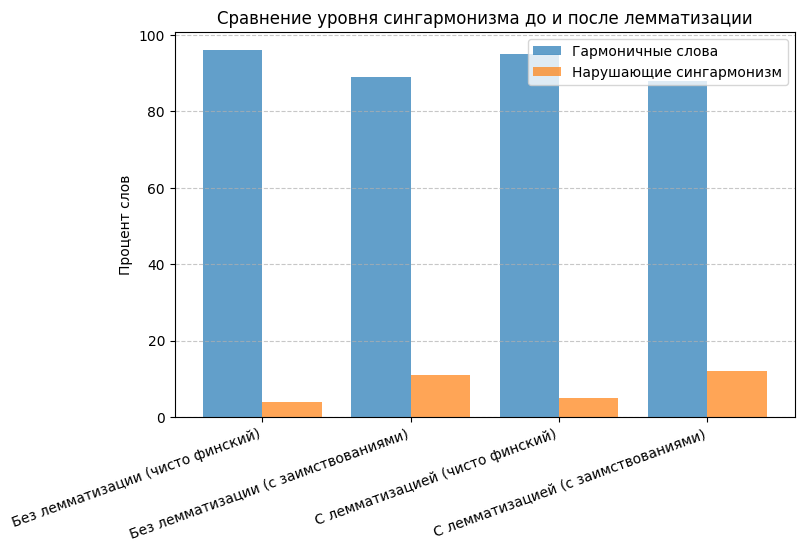

In [ ]:
harmony_stats = {
    "Без лемматизации (чисто финский)": {
        "Гармоничные слова": float(input("Введите процент гармоничных слов (без лемматизации, чисто финский):")),
        "Нарушающие сингармонизм": float(input("Введите процент дисгармоничных слов (без лемматизации, чисто финский):"))
    },
    "Без лемматизации (с заимствованиями)": {
        "Гармоничные слова": float(input("Введите процент гармоничных слов (без лемматизации, с заимствованиями):")),
        "Нарушающие сингармонизм": float(input("Введите процент дисгармоничных слов (без лемматизации, с заимствованиями):"))
    },
    "С лемматизацией (чисто финский)": {
        "Гармоничные слова": float(input("Введите процент гармоничных слов (с лемматизацией, чисто финский):")),
        "Нарушающие сингармонизм": float(input("Введите процент дисгармоничных слов (с лемматизацией, чисто финский):"))
    },
    "С лемматизацией (с заимствованиями)": {
        "Гармоничные слова": float(input("Введите процент гармоничных слов (с лемматизацией, с заимствованиями):")),
        "Нарушающие сингармонизм": float(input("Введите процент дисгармоничных слов (с лемматизацией, с заимствованиями):"))
    },
}

labels = list(harmony_stats.keys())
harmonic_values = [harmony_stats[label]["Гармоничные слова"] for label in labels]
disharmonic_values = [harmony_stats[label]["Нарушающие сингармонизм"] for label in labels]

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, harmonic_values, width, label="Гармоничные слова", alpha=0.7)
ax.bar(x + width/2, disharmonic_values, width, label="Нарушающие сингармонизм", alpha=0.7)

ax.set_ylabel("Процент слов")
ax.set_title("Сравнение уровня сингармонизма до и после лемматизации")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.legend()

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# АНАЛИЗ БИГРАММ И ТРИГРАММ


Здесь мы проанализируем биграммы и триграммы в текстах с лемматизацией. Было интересно посмотреть на распределение гласных.

In [ ]:
def extract_vowel_ngrams(words, vowels, n=2):
    ngram_counts = Counter()

    for word in words:
        word_vowels = [ch for ch in word if ch in vowels]
        ngrams = ["".join(word_vowels[i:i+n]) for i in range(len(word_vowels) - (n-1))]
        ngram_counts.update(ngrams)

    return ngram_counts

def disharmony (ngram_counts, front_vowels, back_vowels):
    violations = {}

    for ngram, count in ngram_counts.items():
        has_front = any(ch in front_vowels for ch in ngram)
        has_back = any(ch in back_vowels for ch in ngram)

        if has_front and has_back:
            violations[ngram] = count

    return violations

In [ ]:
words1 = all_words("sorted_pure.txt")
words2 = all_words("sorted_loanwords.txt")
vowels = set(all_vowels("finnish_vowels.txt"))

front_vowels = {"ä", "ö", "y"}
back_vowels = {"a", "o", "u"}

bigrams1 = extract_vowel_ngrams(words1, vowels, n=2)
bigrams2 = extract_vowel_ngrams(words2, vowels, n=2)

trigrams1 = extract_vowel_ngrams(words1, vowels, n=3)
trigrams2 = extract_vowel_ngrams(words2, vowels, n=3)

harmony_violations_bigrams1 = disharmony(bigrams1, front_vowels, back_vowels)
harmony_violations_bigrams2 = disharmony (bigrams2, front_vowels, back_vowels)

harmony_violations_trigrams1 = disharmony (trigrams1, front_vowels, back_vowels)
harmony_violations_trigrams2 = disharmony(trigrams2, front_vowels, back_vowels)

print("\n**ТОП-10 биграмм в Тексте 1**:", bigrams1.most_common(10))
print("**ТОП-10 биграмм в Тексте 2**:", bigrams2.most_common(10))

print("\n**ТОП-10 триграмм в Тексте 1**:", trigrams1.most_common(10))
print("**ТОП-10 триграмм в Тексте 2**:", trigrams2.most_common(10))

print("\n**Биграммы с нарушением сингармонизма в Тексте 1**:", harmony_violations_bigrams1)
print("**Биграммы с нарушением сингармонизма в Тексте 2**:", harmony_violations_bigrams2)

print("\n**Триграммы с нарушением сингармонизма в Тексте 1**:", harmony_violations_trigrams1)
print("**Триграммы с нарушением сингармонизма в Тексте 2**:", harmony_violations_trigrams2)


**ТОП-10 биграмм в Тексте 1**: [('aa', 800), ('ie', 571), ('ai', 492), ('ia', 439), ('ei', 346), ('ua', 334), ('oi', 321), ('ää', 318), ('ii', 287), ('uu', 241)]
**ТОП-10 биграмм в Тексте 2**: [('ie', 240), ('aa', 212), ('ai', 202), ('ia', 168), ('ei', 164), ('oi', 155), ('ii', 118), ('ua', 96), ('oe', 95), ('ää', 85)]

**ТОП-10 триграмм в Тексте 1**: [('aaa', 183), ('aie', 142), ('iaa', 125), ('aia', 124), ('aai', 110), ('iei', 104), ('oia', 89), ('uaa', 89), ('oie', 81), ('eää', 74)]
**ТОП-10 триграмм в Тексте 2**: [('aie', 66), ('aai', 54), ('iei', 43), ('aaa', 43), ('oia', 43), ('aoi', 40), ('iaa', 40), ('eie', 39), ('aia', 38), ('oie', 31)]

**Биграммы с нарушением сингармонизма в Тексте 1**: {'uä': 7, 'aä': 13, 'uy': 2, 'äa': 22, 'äu': 16, 'äo': 4, 'öo': 1, 'oä': 3, 'ay': 10, 'aö': 1, 'ya': 5, 'öa': 1, 'oy': 1, 'öu': 1}
**Биграммы с нарушением сингармонизма в Тексте 2**: {'ay': 6, 'yo': 4, 'aä': 4, 'uä': 6, 'äa': 4, 'uy': 4, 'öo': 1, 'öa': 5, 'oy': 11, 'oä': 2, 'ya': 6, 'öu': 3,

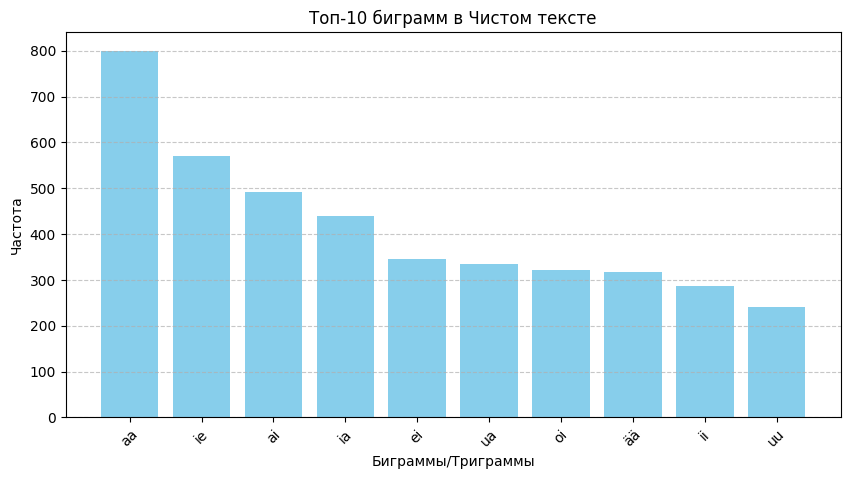

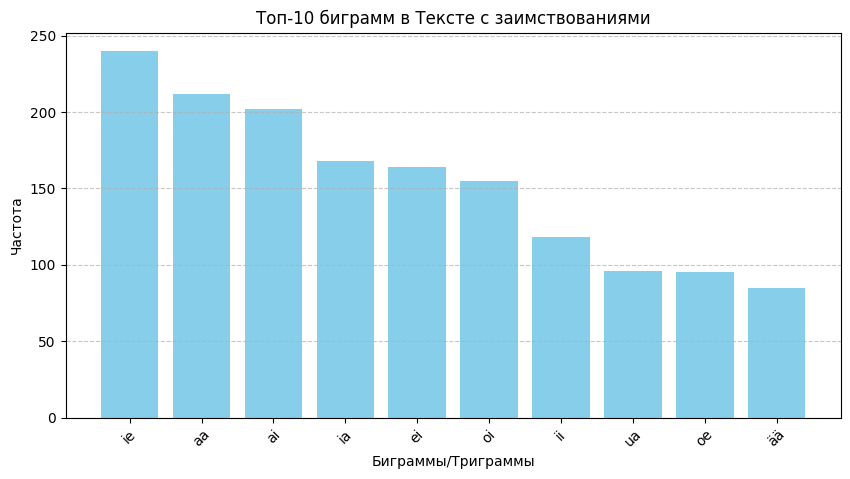

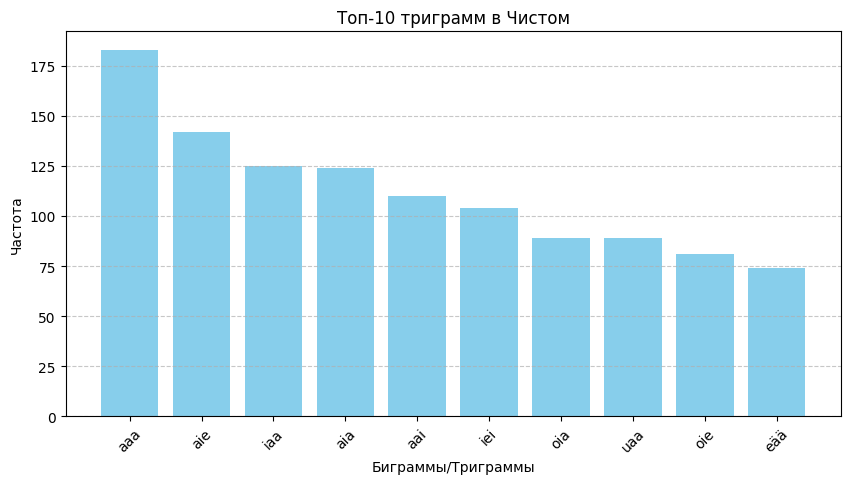

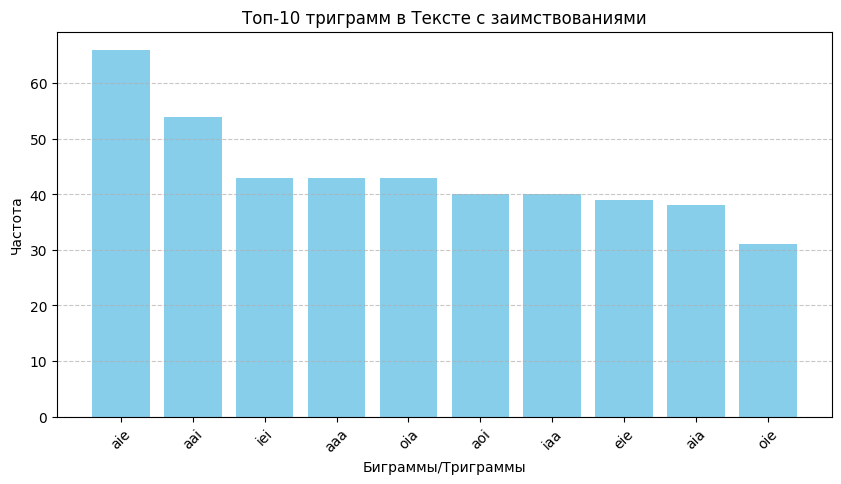

In [ ]:
import matplotlib.pyplot as plt

def plot_top_ngrams(ngram_counts, title, n=10):
    top_ngrams = ngram_counts.most_common(n)
    labels, values = zip(*top_ngrams)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color="skyblue")
    plt.xlabel("Биграммы/Триграммы")
    plt.ylabel("Частота")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Визуализация биграмм
plot_top_ngrams(bigrams1, "Топ-10 биграмм в Чистом тексте")
plot_top_ngrams(bigrams2, "Топ-10 биграмм в Тексте с заимствованиями")

# Визуализация триграмм
plot_top_ngrams(trigrams1, "Топ-10 триграмм в Чистом")
plot_top_ngrams(trigrams2, "Топ-10 триграмм в Тексте с заимствованиями")


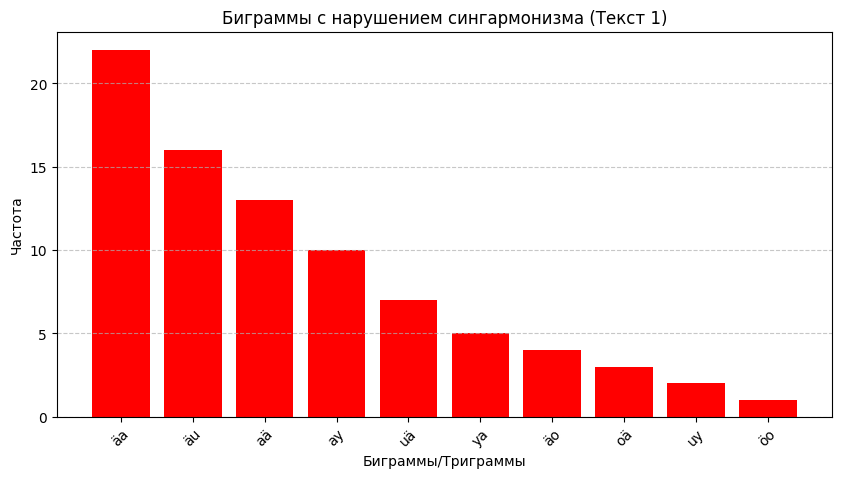

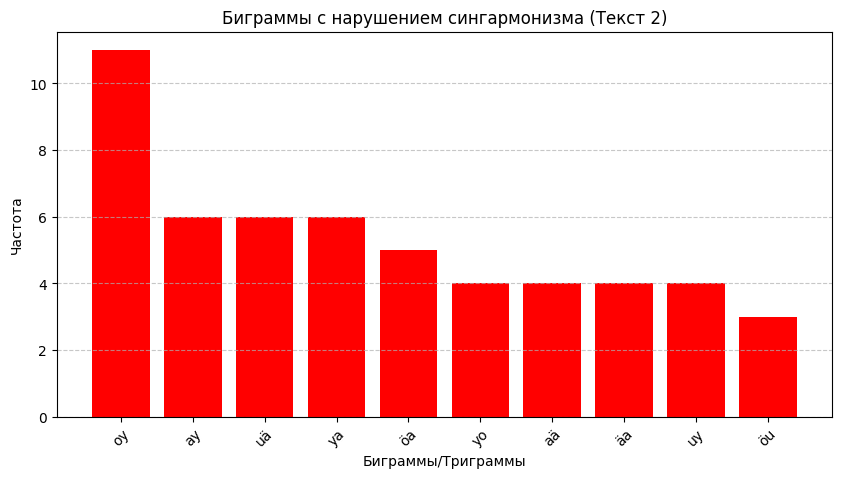

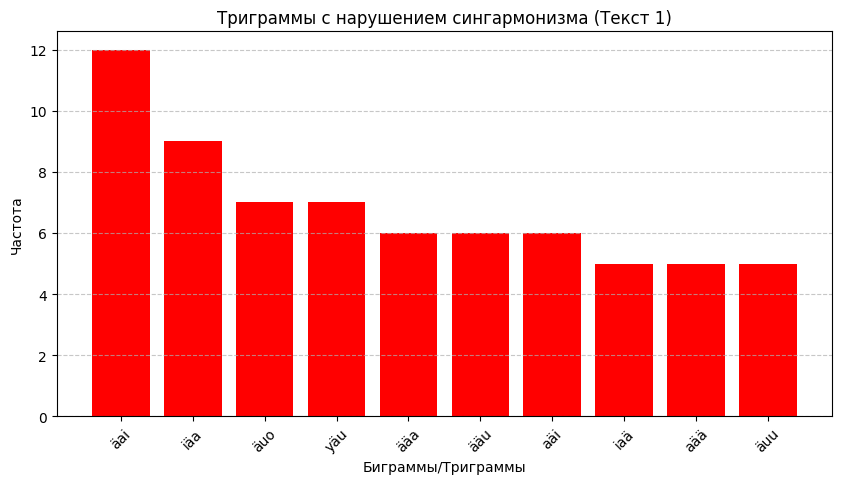

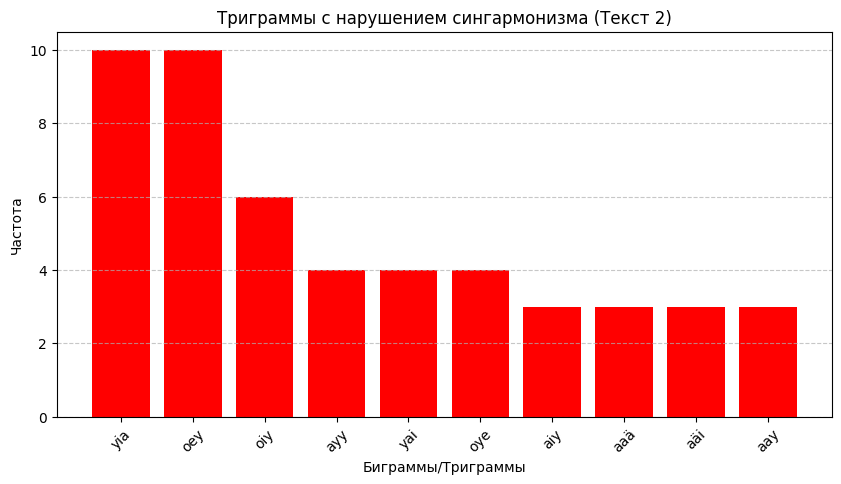

In [ ]:
def plot_violations(violations, title):

    labels, values = zip(*sorted(violations.items(), key=lambda x: x[1], reverse=True)[:10])

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color="red")
    plt.xlabel("Биграммы/Триграммы")
    plt.ylabel("Частота")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_violations(harmony_violations_bigrams1, "Биграммы с нарушением сингармонизма (Текст 1)")
plot_violations(harmony_violations_bigrams2, "Биграммы с нарушением сингармонизма (Текст 2)")

plot_violations(harmony_violations_trigrams1, "Триграммы с нарушением сингармонизма (Текст 1)")
plot_violations(harmony_violations_trigrams2, "Триграммы с нарушением сингармонизма (Текст 2)")


# Выводы по проекту:

1) Текст без заимствований можно считать почти идеально гармоничным (процент нарушений очень мал и большинство слов это опечатки или составные слова)

2) Текст с заимствованиями содержит больше нарушений сингармонизма. Это говорит о том, что некоторые заимствованные слова не подстраиваются под правила языка.

3) После лемматизации процент гармоничных слов увеличивается, что, возможно, свидетельствует о нарушениях именно в образовании морфологических форм слов.

4) Анализ биграмм и триграмм подтверждает нарушения сингармоинизма и позволяет увидеть наиболее частотные сочетания с нарушениями.